In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/'
year = np.arange(151,650,5)

In [5]:
for y in year:
    ds = xr.open_mfdataset(f"{path}atmos.{y:04d}010100-{y+4:04d}123123*.nc", use_cftime=True)
    ds_static = xr.open_mfdataset(f"{path}atmos.static.nc", use_cftime=True)

    wind = (ds.u_ref**2 + ds.v_ref**2)**0.5

    idx_SO = (ds_static.lat <=-30) & (ds_static.land_mask < .5)
    idx_10m = (wind >= 10) & idx_SO

    idx_3day_winds = idx_10m.rolling(time=12,center=True).sum() == 12

    idx_padded = idx_3day_winds.copy()

    n = 6
    for i in range(1, n+1):
        idx_padded = idx_padded | idx_3day_winds.shift(time=i, fill_value=False) | idx_3day_winds.shift(time=-i, fill_value=False)


    ds_out = xr.Dataset(
        data_vars=dict(
            mask_winds_3day=(["time", "lat", "lon"], idx_padded.data),
        ),
        coords=dict(
            time=ds.time.data,
            lat=ds.lat.data,
            lon=ds.lon.data,
        ),
        attrs=dict(description='Mask for winds over 10ms-1 for at least 3 days')
    )

    ds_out.to_netcdf(f'/work/Katherine.Turner/tempest-extremes/CM4_cmip/wind_blobs/wind_mask_{y:03d}_{y+4:03d}.nc')

## Reading in wind masks, creating area averages, and making monthly datasets for comparison

In [8]:
import om4labs.om4common as om4

In [26]:
ds = xr.open_mfdataset(f'/work/Katherine.Turner/tempest-extremes/ESM4_cmip/wind_blobs/wind_mask_*.nc')
ds_static = xr.open_mfdataset(f"{path}atmos.static.nc", use_cftime=True)

In [11]:
dA = om4.compute_area_regular_grid(ds_static)

In [28]:
windy_area = (ds.mask_winds_3day * dA).sum(dim=['lat','lon'])

In [29]:
windy_area_month = windy_area.resample(time='M').mean().compute()

In [30]:
windy_area_month.to_dataset(name='SO_windy_area').to_netcdf('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_SO_windy_area.nc')

## Comparing wind statistics to storm statistics

In [100]:
mod = 'CM4'

ds_storms = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_monthly_storms.nc')
ds_winds = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_SO_windy_area.nc')

In [101]:
seasonal_storms = ds_storms.resample(time='QS-DEC').sum()
seasonal_windarea = ds_winds.resample(time='QS-DEC').mean()

In [102]:
idx_djf = seasonal_storms.time.dt.month==12
idx_jja = seasonal_storms.time.dt.month==6

storms_djf = seasonal_storms.center_counts[idx_djf][1:-1]
winds_djf = seasonal_windarea.SO_windy_area[idx_djf][1:-1]

storms_jja = seasonal_storms.center_counts[idx_jja]
winds_jja = seasonal_windarea.SO_windy_area[idx_jja]

In [43]:
xr.corr(storms_djf, winds_djf)

<xarray.DataArray ()>
array(-0.33913246)

In [44]:
xr.corr(storms_jja, winds_jja)

<xarray.DataArray ()>
array(-0.29056461)

## Wind distributions of stormy/non-stormy years and windy/non-windy years

In [103]:
lo_jja_storms = storms_jja.sortby(storms_jja).time.dt.year[:50]
hi_jja_storms = storms_jja.sortby(storms_jja).time.dt.year[-50:]

lo_jja_winds = winds_jja.sortby(winds_jja).time.dt.year[:50]
hi_jja_winds = winds_jja.sortby(winds_jja).time.dt.year[-50:]

idx_SO = (ds_static.land_mask < .5) & (ds_static.lat <= -30)

In [104]:
i=6

ds_wind6hr = xr.open_mfdataset(f'/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/winds_daily/atmos.0{i}*_ref.nc')

idx_lo_jja_winds = ds_wind6hr.time.dt.month.isin([6,7,8]) & ds_wind6hr.time.dt.year.isin(lo_jja_winds)  
idx_lo_jja_storms = ds_wind6hr.time.dt.month.isin([6,7,8]) & ds_wind6hr.time.dt.year.isin(lo_jja_storms)
idx_hi_jja_winds = ds_wind6hr.time.dt.month.isin([6,7,8]) & ds_wind6hr.time.dt.year.isin(hi_jja_winds) 
idx_hi_jja_storms = ds_wind6hr.time.dt.month.isin([6,7,8]) & ds_wind6hr.time.dt.year.isin(hi_jja_storms)

ds_out_lo_jja_winds = xr.Dataset(
    data_vars=dict(
        u_ref = (['time', 'lat', 'lon'], ds_wind6hr.u_ref.sel(lat=slice(-90,-30))[idx_lo_jja_winds,:,:].data),
        v_ref = (['time', 'lat', 'lon'], ds_wind6hr.v_ref.sel(lat=slice(-90,-30))[idx_lo_jja_winds,:,:].data),
    ),
    coords=dict(
        lon = ('lon', ds_wind6hr.lon.data),
        lat = ('lat', ds_wind6hr.lat.sel(lat=slice(-90,-30)).data),
        time = ('time', ds_wind6hr.time[idx_lo_jja_winds].data),
    ),
)

ds_out_hi_jja_winds = xr.Dataset(
    data_vars=dict(
        u_ref = (['time', 'lat', 'lon'], ds_wind6hr.u_ref.sel(lat=slice(-90,-30))[idx_hi_jja_winds,:,:].data),
        v_ref = (['time', 'lat', 'lon'], ds_wind6hr.v_ref.sel(lat=slice(-90,-30))[idx_hi_jja_winds,:,:].data),
    ),
    coords=dict(
        lon = ('lon', ds_wind6hr.lon.data),
        lat = ('lat', ds_wind6hr.lat.sel(lat=slice(-90,-30)).data),
        time = ('time', ds_wind6hr.time[idx_hi_jja_winds].data),
    ),
)

ds_out_lo_jja_storms = xr.Dataset(
    data_vars=dict(
        u_ref = (['time', 'lat', 'lon'], ds_wind6hr.u_ref.sel(lat=slice(-90,-30))[idx_lo_jja_storms,:,:].data),
        v_ref = (['time', 'lat', 'lon'], ds_wind6hr.v_ref.sel(lat=slice(-90,-30))[idx_lo_jja_storms,:,:].data),
    ),
    coords=dict(
        lon = ('lon', ds_wind6hr.lon.data),
        lat = ('lat', ds_wind6hr.lat.sel(lat=slice(-90,-30)).data),
        time = ('time', ds_wind6hr.time[idx_lo_jja_storms].data),
    ),
)

ds_out_hi_jja_storms = xr.Dataset(
    data_vars=dict(
        u_ref = (['time', 'lat', 'lon'], ds_wind6hr.u_ref.sel(lat=slice(-90,-30))[idx_hi_jja_storms,:,:].data),
        v_ref = (['time', 'lat', 'lon'], ds_wind6hr.v_ref.sel(lat=slice(-90,-30))[idx_hi_jja_storms,:,:].data),
    ),
    coords=dict(
        lon = ('lon', ds_wind6hr.lon.data),
        lat = ('lat', ds_wind6hr.lat.sel(lat=slice(-90,-30)).data),
        time = ('time', ds_wind6hr.time[idx_hi_jja_storms].data),
    ),
)

ds_out_lo_jja_winds.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_lo_jja_winds_0{i}00.nc')
ds_out_hi_jja_winds.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_hi_jja_winds_0{i}00.nc')
ds_out_lo_jja_storms.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_lo_jja_storms_0{i}00.nc')
ds_out_hi_jja_storms.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_hi_jja_storms_0{i}00.nc')

In [8]:
for mod in ['CM4', 'ESM4']:
    ds = xr.open_mfdataset(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_hi_jja_storms_*.nc")
    ds.to_netcdf(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/{mod}_cmip_hi_jja_storms.nc")

In [30]:
import numpy as np
import xarray as xr

ds_lo_storms = xr.open_dataset(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/CM4_cmip_lo_jja_storms.nc")
ds_hi_storms = xr.open_dataset(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/CM4_cmip_hi_jja_storms.nc")
ds_lo_winds = xr.open_dataset(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/CM4_cmip_lo_jja_winds.nc")
ds_hi_winds = xr.open_dataset(f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/winds_6hr_extremes/CM4_cmip_hi_jja_winds.nc")

In [30]:
# Assuming lat dimension is named 'lat'
weights = np.cos(np.deg2rad(ds_storms.lat))
# Broadcast to 2D or 3D to match wind_mag shape
weights_2d = ds_lo_storms.u_ref * 0 + weights  # works with broadcasting

In [46]:
ds_static = xr.open_mfdataset(f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/atmos.static.nc", use_cftime=True)
idx_SO = (ds_static.sel(lat=slice(-90,-30)).land_mask < .7)
idx_SO_2d = ds_lo_storms.u_ref * 0 + idx_SO  # works with broadcasting

In [47]:
weight_vals = weights_2d.values.flatten()
mask_vals = idx_SO_2d.values.flatten()
weight_vals = weight_vals * mask_vals

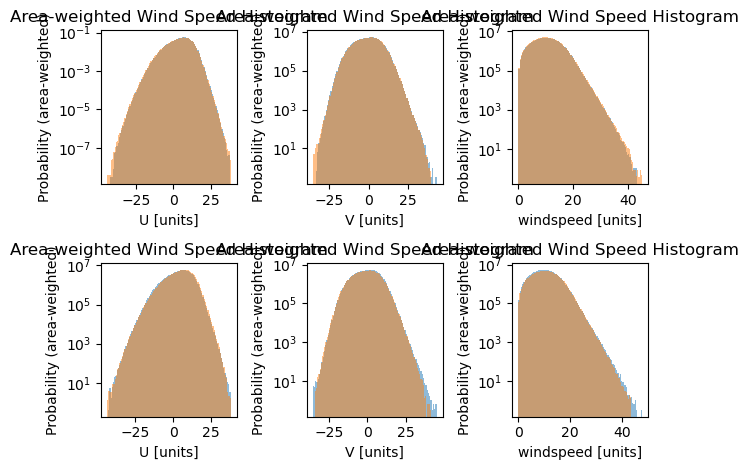

In [53]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3)

axs=axs.flatten()

axs[0].hist(ds_lo_storms.u_ref.values.flatten(), 
            weights=weight_vals, density=True,
            bins=100, alpha=0.5)
axs[0].hist(ds_hi_storms.u_ref.values.flatten(), 
            weights=weight_vals, density=True, 
            bins=100, alpha=0.5)
axs[0].set_xlabel('U [units]')
axs[0].set_ylabel('Probability (area-weighted)')
axs[0].set_title('Area-weighted Wind Speed Histogram')
axs[0].set_yscale('log')

axs[1].hist(ds_lo_storms.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[1].hist(ds_hi_storms.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[1].set_xlabel('V [units]')
axs[1].set_ylabel('Probability (area-weighted)')
axs[1].set_title('Area-weighted Wind Speed Histogram')
axs[1].set_yscale('log')

axs[2].hist(((ds_lo_storms.u_ref**2 + ds_lo_storms.v_ref**2)**0.5).values.flatten(), 
            weights=weight_vals, bins=100, alpha=0.5)
axs[2].hist(((ds_hi_storms.u_ref**2 + ds_hi_storms.v_ref**2)**0.5).values.flatten(), 
            weights=weight_vals, bins=100, alpha=0.5)
axs[2].set_xlabel('windspeed [units]')
axs[2].set_ylabel('Probability (area-weighted)')
axs[2].set_title('Area-weighted Wind Speed Histogram')
axs[2].set_yscale('log')

axs[3].hist(ds_lo_winds.u_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[3].hist(ds_hi_winds.u_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[3].set_xlabel('U [units]')
axs[3].set_ylabel('Probability (area-weighted)')
axs[3].set_title('Area-weighted Wind Speed Histogram')
axs[3].set_yscale('log')

axs[4].hist(ds_lo_winds.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[4].hist(ds_hi_winds.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
axs[4].set_xlabel('V [units]')
axs[4].set_ylabel('Probability (area-weighted)')
axs[4].set_title('Area-weighted Wind Speed Histogram')
axs[4].set_yscale('log')

axs[5].hist(((ds_lo_winds.u_ref**2 + ds_lo_winds.v_ref**2)**0.5).values.flatten(), 
            weights=weight_vals, bins=100, alpha=0.5)
axs[5].hist(((ds_hi_winds.u_ref**2 + ds_hi_winds.v_ref**2)**0.5).values.flatten(), 
            weights=weight_vals, bins=100, alpha=0.5)
axs[5].set_xlabel('windspeed [units]')
axs[5].set_ylabel('Probability (area-weighted)')
axs[5].set_title('Area-weighted Wind Speed Histogram')
axs[5].set_yscale('log')

plt.tight_layout()

In [55]:
## trying for daily max winds

ds1 = ds_lo_storms.resample(time='D').max()
ds2 = ds_hi_storms.resample(time='D').max()
ds3 = ds_lo_winds.resample(time='D').max()
ds4 = ds_hi_winds.resample(time='D').max()

In [71]:
# Broadcast to 2D or 3D to match wind_mag shape
weights_2d = ds1.u_ref * 0 + weights  # works with broadcasting
idx_SO_2d = ds1.u_ref * 0 + idx_SO  # works with broadcasting

weight_vals_ds1 = weights_2d.values.flatten()
mask_vals_ds1 = idx_SO_2d.values.flatten()
weight_vals_ds1 = weight_vals_ds1 * mask_vals_ds1

weights_2d = ds2.u_ref * 0 + weights  # works with broadcasting
idx_SO_2d = ds2.u_ref * 0 + idx_SO  # works with broadcasting

weight_vals_ds2 = weights_2d.values.flatten()
mask_vals_ds2 = idx_SO_2d.values.flatten()
weight_vals_ds2 = weight_vals_ds2 * mask_vals_ds2

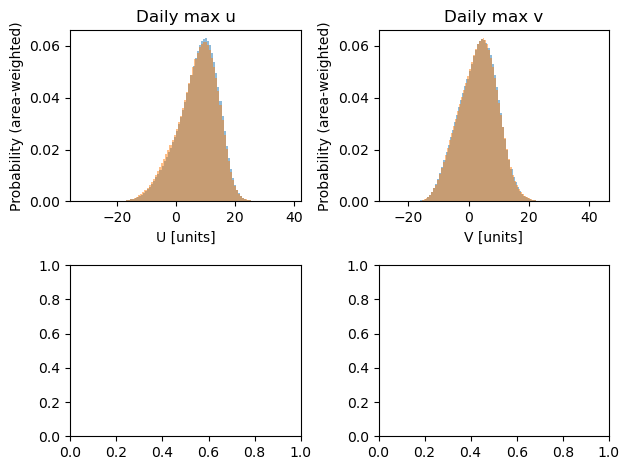

In [77]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs=axs.flatten()

axs[0].hist(ds1.u_ref.values.flatten(), 
            weights=weight_vals_ds1, density=True,
            bins=100, alpha=0.5)
axs[0].hist(ds2.u_ref.values.flatten(), 
            weights=weight_vals_ds2, density=True, 
            bins=100, alpha=0.5)
axs[0].set_xlabel('U [units]')
axs[0].set_ylabel('Probability (area-weighted)')
axs[0].set_title('Daily max u')
#axs[0].set_yscale('log')

axs[1].hist(ds1.v_ref.values.flatten(), weights=weight_vals_ds1, density=True,
            bins=100, alpha=0.5)
axs[1].hist(ds2.v_ref.values.flatten(), weights=weight_vals_ds2, density=True,
            bins=100, alpha=0.5)
axs[1].set_xlabel('V [units]')
axs[1].set_ylabel('Probability (area-weighted)')
axs[1].set_title('Daily max v')
#axs[1].set_yscale('log')

#axs[2].hist(ds3.u_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
#axs[2].hist(ds4.u_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
#axs[2].set_xlabel('U [units]')
#axs[2].set_ylabel('Probability (area-weighted)')
#axs[2].set_title('Area-weighted Wind Speed Histogram')
#axs[2].set_yscale('log')

#axs[3].hist(ds3.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
#axs[3].hist(ds4.v_ref.values.flatten(), weights=weight_vals, bins=100, alpha=0.5)
#axs[3].set_xlabel('V [units]')
#axs[3].set_ylabel('Probability (area-weighted)')
#axs[3].set_title('Area-weighted Wind Speed Histogram')
#axs[3].set_yscale('log')

plt.tight_layout()